In [38]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplfinance as mpf
import mplcursors
import seaborn as sns
import matplotlib.gridspec as gridspec
import datetime

from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands

import xgboost as xgb

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import TimeSeriesSplit

import dash
from dash import dcc, html
import plotly.graph_objs as go
from dash.dependencies import Input, Output

print("All libraries imported!")


All libraries imported!


In [39]:
TICKER = 'GEV'
# Use a timezone-aware current time
current_time = pd.Timestamp.now(tz='UTC')

# Define start_date as 2 years ago and split_date as 1 year ago (for training/backtesting)
start_date = current_time - pd.Timedelta(days=730)  # Past 2 years
split_date = current_time - pd.Timedelta(days=180)    # Split: first year for training, last year for testing

def prepare_data():
    # Download hourly data from the past 2 years
    stock_data = yf.download(TICKER, start=start_date, end=current_time, interval='1h')
    df = stock_data.copy()
    df.columns = df.columns.get_level_values(0)
    df = df.rename(columns={'Vol': 'Volume'})
    
    df['normalized'] = (df['Close'] - df['Low']) / ((df['High'] - df['Low']).replace(0, np.nan)).fillna(0.5)
    
    def calculate_slope(series):
        return np.polyfit(np.arange(len(series)), series, 1)[0] if len(series) > 1 else np.nan
    windows = [3, 5, 10, 20]
    for w in windows:
        df[f'regression_{w}d'] = df['Close'].rolling(window=w, min_periods=2).apply(calculate_slope, raw=True)

    df['RSI'] = RSIIndicator(df['Close'], window=14).rsi()
    macd = MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_signal'] = macd.macd_signal()
    df['Volatility'] = df['Close'].pct_change().rolling(5).std()

    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['MA_50'] = df['Close'].rolling(window=50).mean()

    bb_indicator = BollingerBands(df['Close'], window=20, window_dev=2)
    df['BB_upper'] = bb_indicator.bollinger_hband()
    df['BB_lower'] = bb_indicator.bollinger_lband()
    df['BB_middle'] = bb_indicator.bollinger_mavg()
    
    df['Volume_MA_20'] = df['Volume'].rolling(window=20).mean()

    local_min = [i for i in range(5, len(df)) if df['Close'].iloc[i] < df['Close'].iloc[i-5:i].min()]
    local_max = [i for i in range(5, len(df)) if df['Close'].iloc[i] > df['Close'].iloc[i-5:i].max()]
    
    # 0 -> Buy signal, 1 -> Sell signal, 2 -> Natural (default)
    df['target'] = 2  # default to natural
    df.iloc[local_min, df.columns.get_loc('target')] = 0  # Buy signal
    df.iloc[local_max, df.columns.get_loc('target')] = 1  # Sell signal
    
    features = ['normalized', 'Volume', 'RSI', 'MACD', 'Volatility',
                'regression_3d', 'regression_5d', 'regression_10d', 'regression_20d',
                'MA_20', 'MA_50', 'BB_upper', 'BB_middle', 'BB_lower', 'Volume_MA_20']
    
    df_features = df.dropna(subset=features).copy()
    df_features.sort_index(inplace=True)

    model_df = df_features.copy()
    
    return df_features, model_df, features

try:
    df_features, model_df, features = prepare_data()
    print("Data preparation successful!")
    print("Sample training data:")
    print(model_df[['Close', 'RSI', 'MACD', 'regression_5d', 'target']].tail())
except Exception as e:
    print(f"Data error: {str(e)}")

# Adjust the train/test split based on the new 2-year data period
train_df = model_df[model_df.index < split_date].copy()
test_df  = df_features[df_features.index >= split_date].copy()

print(f"\nTraining Data: {train_df.shape[0]} rows")
print(f"Backtesting Data: {test_df.shape[0]} rows")


[*********************100%***********************]  1 of 1 completed


Data preparation successful!
Sample training data:
Price                           Close        RSI      MACD  regression_5d  \
Datetime                                                                    
2025-02-03 19:30:00+00:00  365.075012  45.764192 -1.365328       0.486002   
2025-02-03 20:30:00+00:00  361.660004  42.613868 -1.729512       0.337503   
2025-02-04 14:30:00+00:00  359.459991  40.671474 -2.170632      -0.885004   
2025-02-04 15:30:00+00:00  354.880005  36.900589 -2.856857      -2.503500   
2025-02-04 16:30:00+00:00  351.679993  34.494169 -3.617212      -3.357004   

Price                      target  
Datetime                           
2025-02-03 19:30:00+00:00       1  
2025-02-03 20:30:00+00:00       2  
2025-02-04 14:30:00+00:00       0  
2025-02-04 15:30:00+00:00       0  
2025-02-04 16:30:00+00:00       0  

Training Data: 574 rows
Backtesting Data: 845 rows


In [40]:
def train_xgb(model_df, features, decision_threshold=0.3):
    X = model_df[features]
    y = model_df['target'].astype(int)
    
    classes = np.unique(y)
    class_counts = y.value_counts().to_dict()
    total = len(y)
    class_weights = {cls: total/(len(classes)*class_counts[cls]) for cls in classes}
    print("Computed class weights:", class_weights)
    
    sample_weights = y.map(class_weights)
    
    xgb_clf = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        eval_metric='mlogloss',
        max_depth=5,
        n_estimators=200,
        random_state=42
    )
    
    tscv = TimeSeriesSplit(n_splits=5)
    fold_metrics = []
    
    print("\nStarting 5-Fold Time Series Cross-Validation with Threshold Tuning (XGBoost):\n")
    for fold, (train_idx, valid_idx) in enumerate(tscv.split(X)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        sw_train = sample_weights.iloc[train_idx]
        
        xgb_clf.fit(X_train, y_train, sample_weight=sw_train)
        proba = xgb_clf.predict_proba(X_valid)

        y_pred = []
        for p in proba:
            if p[0] >= decision_threshold or p[1] >= decision_threshold:
                y_pred.append(0 if p[0] >= p[1] else 1)
            else:
                y_pred.append(2)
        y_pred = np.array(y_pred)
        
        report_dict = classification_report(y_valid, y_pred, output_dict=True, zero_division=0)
        accuracy = accuracy_score(y_valid, y_pred)
        confusion = confusion_matrix(y_valid, y_pred)
        
        fold_metrics.append({
            'fold': fold,
            'accuracy': accuracy,
            'report': report_dict,
            'confusion': confusion
        })
        
        print(f"Fold {fold + 1} Metrics:")
        print(f"Accuracy: {accuracy:.3f}")
        for cls in ['0', '1', '2']:
            if cls in report_dict:
                precision = report_dict[cls]['precision']
                recall = report_dict[cls]['recall']
                f1 = report_dict[cls]['f1-score']
                support = report_dict[cls]['support']
                print(f"  Class {cls} -- Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {f1:.3f}, Support: {support}")
        print("Macro Avg --",
              f"Precision: {report_dict['macro avg']['precision']:.3f},",
              f"Recall: {report_dict['macro avg']['recall']:.3f},",
              f"F1-Score: {report_dict['macro avg']['f1-score']:.3f}")
        print("Confusion Matrix:")
        print(confusion)
        print("-" * 50, "\n")
    
    xgb_clf.fit(X, y, sample_weight=sample_weights)
    return xgb_clf, fold_metrics

model, fold_metrics = train_xgb(train_df, features, decision_threshold=0.3)


Computed class weights: {np.int64(0): 1.5065616797900263, np.int64(1): 1.1595959595959595, np.int64(2): 0.6784869976359338}

Starting 5-Fold Time Series Cross-Validation with Threshold Tuning (XGBoost):

Fold 1 Metrics:
Accuracy: 0.716
  Class 0 -- Precision: 0.576, Recall: 0.905, F1-Score: 0.704, Support: 21.0
  Class 1 -- Precision: 0.808, Recall: 0.778, F1-Score: 0.792, Support: 27.0
  Class 2 -- Precision: 0.778, Recall: 0.596, F1-Score: 0.675, Support: 47.0
Macro Avg -- Precision: 0.720, Recall: 0.759, F1-Score: 0.724
Confusion Matrix:
[[19  0  2]
 [ 0 21  6]
 [14  5 28]]
-------------------------------------------------- 

Fold 2 Metrics:
Accuracy: 0.811
  Class 0 -- Precision: 0.783, Recall: 0.947, F1-Score: 0.857, Support: 19.0
  Class 1 -- Precision: 0.743, Recall: 0.897, F1-Score: 0.812, Support: 29.0
  Class 2 -- Precision: 0.892, Recall: 0.702, F1-Score: 0.786, Support: 47.0
Macro Avg -- Precision: 0.806, Recall: 0.849, F1-Score: 0.818
Confusion Matrix:
[[18  0  1]
 [ 0 26 

In [41]:
class Backtester:
    def __init__(self, initial_balance=3000, fee=0.001):
        """
        fee: transaction fee as a fraction (e.g., 0.001 means 0.1% fee per trade)
        """
        self.initial_balance = initial_balance
        self.fee = fee
        self.reset()
        
    def reset(self):
        self.cash = self.initial_balance
        self.shares = 0
        self.trades = []
        self.portfolio = [self.initial_balance]
        self.peak = self.initial_balance
        self.drawdown = 0
        self.drawdown_history = [] 
        
    def run(self, data, model, features, threshold=0.4):
        self.reset()
        data = data.copy()

        # For simplicity, using probability of class 1 as the signal
        data['pred_proba'] = model.predict_proba(data[features])[:, 1]
        data['signal'] = (data['pred_proba'] > threshold).astype(int)
        
        for idx, row in data.iterrows():
            current_value = self.cash + self.shares * row['Close']
            self.portfolio.append(current_value)
            self.peak = max(self.peak, current_value)
            current_drawdown = (self.peak - current_value) / self.peak
            self.drawdown = max(self.drawdown, current_drawdown)
            self.drawdown_history.append(current_drawdown)
            
            if self.shares == 0 and row['signal'] == 0:
                # Calculate fee cost on purchase
                cost = self.cash * self.fee
                effective_cash = self.cash - cost
                self.shares = effective_cash / row['Close']
                self.cash = 0
                self.trades.append({'type': 'buy', 'date': idx, 'price': row['Close'], 'fee': cost})
            
            elif self.shares > 0 and row['signal'] == 1:
                proceeds = self.shares * row['Close']
                fee_cost = proceeds * self.fee
                effective_proceeds = proceeds - fee_cost
                self.cash = effective_proceeds
                self.trades.append({
                    'type': 'sell',
                    'date': idx,
                    'price': row['Close'],
                    'fee': fee_cost,
                    'profit': effective_proceeds - self.initial_balance
                })
                self.shares = 0
        
        return self.trades, self.portfolio[1:]
    
bt = Backtester(initial_balance=3000, fee=0.001)
trades, portfolio = bt.run(test_df, model, features, threshold=0.4)

print("Trades executed:")
for trade in trades:
    print(trade)


Trades executed:
{'type': 'buy', 'date': Timestamp('2024-08-08 18:30:00+0000', tz='UTC'), 'price': np.float64(176.25999450683594), 'fee': 3.0}
{'type': 'sell', 'date': Timestamp('2024-08-08 19:30:00+0000', tz='UTC'), 'price': np.float64(177.19000244140625), 'fee': np.float64(3.0128131956585253), 'profit': np.float64(9.800382462866764)}
{'type': 'buy', 'date': Timestamp('2024-08-09 13:30:00+0000', tz='UTC'), 'price': np.float64(173.6699981689453), 'fee': np.float64(3.009800382462867)}
{'type': 'sell', 'date': Timestamp('2024-08-09 16:30:00+0000', tz='UTC'), 'price': np.float64(177.69000244140625), 'fee': np.float64(3.0763898860119903), 'profit': np.float64(73.31349612597842)}
{'type': 'buy', 'date': Timestamp('2024-08-12 13:30:00+0000', tz='UTC'), 'price': np.float64(176.68499755859375), 'fee': np.float64(3.0733134961259783)}
{'type': 'sell', 'date': Timestamp('2024-08-13 15:30:00+0000', tz='UTC'), 'price': np.float64(178.4149932861328), 'fee': np.float64(3.100302171320811), 'profit': n

/home/harry/StockTradingbot/myenv/lib/python3.11/site-packages/mplfinance/_arg_validators.py:84: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




GEV ML Strategy Performance Summary:

Initial Balance: $3,000.00
Final Balance:   $3,409.71
Total Return:    13.66%
Max Drawdown:    26.5%
Win Rate:        100.0%
Total Trades:    126


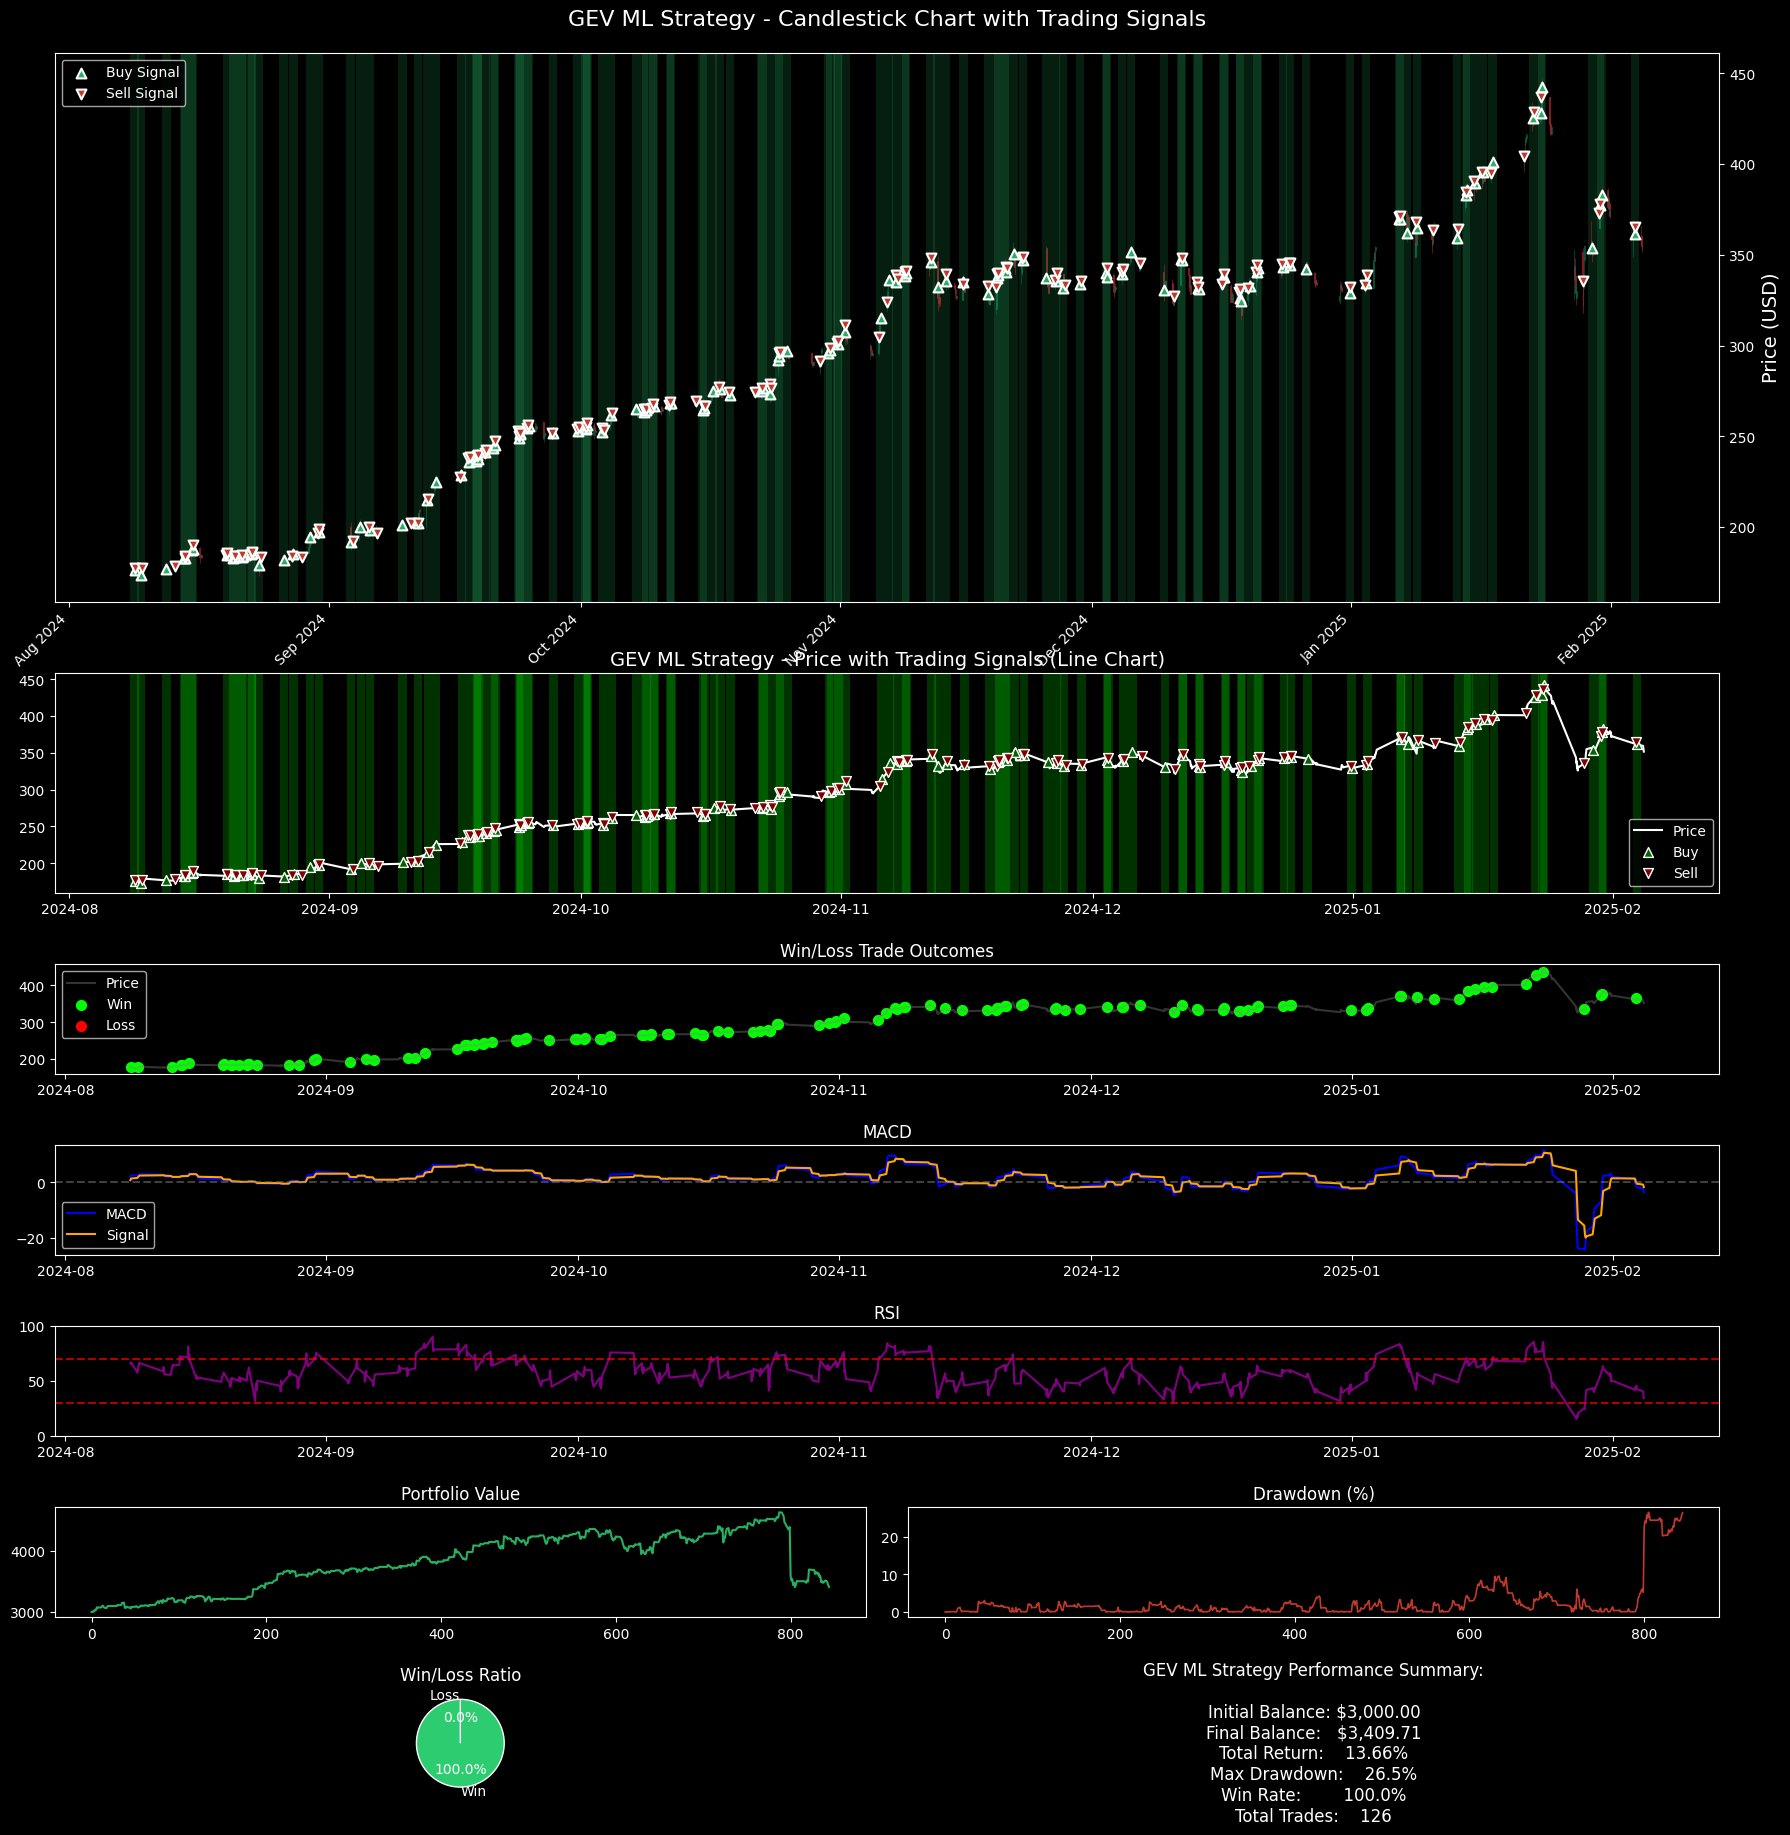

In [42]:
plt.style.use('dark_background')

def plot_strategy_analysis(name, trades, portfolio, drawdowns, data, initial_balance):
    # For plotting, restrict to the backtesting period (last year)
    test_data = data[data.index >= split_date]
    buy_dates = [t['date'] for t in trades if t['type'] == 'buy']
    sell_dates = [t['date'] for t in trades if t['type'] == 'sell']
    
    fig = plt.figure(figsize=(18, 20))
    gs = gridspec.GridSpec(8, 2, height_ratios=[5, 2, 1, 1, 1, 1, 1, 1])

    ax1 = plt.subplot(gs[0, :])
    ohlc_data = test_data[['Open', 'High', 'Low', 'Close']].reset_index()
    # If the datetime column is not named 'Date', rename it to 'Date'
    if 'Date' not in ohlc_data.columns:
        ohlc_data.rename(columns={ohlc_data.columns[0]: 'Date'}, inplace=True)
    ohlc_data['Date'] = ohlc_data['Date'].map(mdates.date2num)
    
    mpf.plot(test_data, type='candle', ax=ax1, style='charles',
             show_nontrading=True)
    for bd in buy_dates:
        ax1.axvspan(mdates.date2num(bd - pd.Timedelta(hours=12)), 
                    mdates.date2num(bd + pd.Timedelta(hours=12)), 
                    facecolor='#2ecc71', alpha=0.15)
    ax1.scatter([mdates.date2num(d) for d in buy_dates], 
                test_data.loc[buy_dates, 'Close'],
                marker='^', color='#27ae60', s=50, edgecolors='white',
                linewidth=1.5, label='Buy Signal', zorder=3)
    ax1.scatter([mdates.date2num(d) for d in sell_dates], 
                test_data.loc[sell_dates, 'Close'],
                marker='v', color='#c0392b', s=50, edgecolors='white',
                linewidth=1.5, label='Sell Signal', zorder=3)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    ax1.set_title(f'{name} - Candlestick Chart with Trading Signals', fontsize=16, pad=20)
    ax1.set_ylabel('Price (USD)', fontsize=14)
    ax1.legend(loc='upper left')
    mplcursors.cursor(ax1, hover=True)

    ax2 = plt.subplot(gs[1, :])
    ax2.plot(test_data.index, test_data['Close'], color='white', lw=1.5, label='Price')
    for bd in buy_dates:
        ax2.axvspan(bd - pd.Timedelta(hours=12), bd + pd.Timedelta(hours=12), 
                    facecolor='lime', alpha=0.2)
    ax2.scatter(buy_dates, test_data.loc[buy_dates, 'Close'], 
                marker='^', color='darkgreen', s=50, edgecolors='white', 
                linewidth=1, label='Buy', zorder=3)
    ax2.scatter(sell_dates, test_data.loc[sell_dates, 'Close'],
                marker='v', color='maroon', s=50, edgecolors='white', 
                linewidth=1, label='Sell', zorder=3)
    ax2.set_title(f'{name} - Price with Trading Signals (Line Chart)', fontsize=14)
    ax2.legend()
    mplcursors.cursor(ax2, hover=True)

    ax3 = plt.subplot(gs[2, :])
    win_dates = [t['date'] for t in trades if t['type'] == 'sell' and t.get('profit', 0) > 0]
    loss_dates = [t['date'] for t in trades if t['type'] == 'sell' and t.get('profit', 0) <= 0]
    ax3.plot(test_data.index, test_data['Close'], color='gray', alpha=0.4, label='Price')
    ax3.scatter(win_dates, test_data.loc[win_dates, 'Close'], 
                color='lime', s=50, label='Win')
    ax3.scatter(loss_dates, test_data.loc[loss_dates, 'Close'],
                color='red', s=50, label='Loss')
    ax3.set_title('Win/Loss Trade Outcomes', fontsize=12)
    ax3.legend()
    
    ax4 = plt.subplot(gs[3, :])
    ax4.plot(test_data.index, test_data['MACD'], label='MACD', color='blue')
    ax4.plot(test_data.index, test_data['MACD_signal'], label='Signal', color='orange')
    ax4.axhline(0, color='grey', ls='--', alpha=0.5)
    ax4.set_title('MACD', fontsize=12)
    ax4.legend()

    ax5 = plt.subplot(gs[4, :])
    ax5.plot(test_data.index, test_data['RSI'], color='purple')
    ax5.axhline(30, color='red', ls='--', alpha=0.7)
    ax5.axhline(70, color='red', ls='--', alpha=0.7)
    ax5.set_ylim(0, 100)
    ax5.set_title('RSI', fontsize=12)

    ax6 = plt.subplot(gs[5, 0])
    ax6.plot(portfolio, color='#27ae60', lw=1.5)
    ax6.set_title('Portfolio Value', fontsize=12)
    ax7 = plt.subplot(gs[5, 1])
    ax7.plot([d * 100 for d in drawdowns], color='#c0392b', lw=1.2)
    ax7.set_title('Drawdown (%)', fontsize=12)

    ax8 = plt.subplot(gs[6, 0])
    profits = [t.get('profit', 0) for t in trades if t['type'] == 'sell']
    win_rate = sum(p > 0 for p in profits) / len(profits) if profits else 0
    ax8.pie([win_rate, 1 - win_rate], labels=['Win', 'Loss'],
            colors=['#2ecc71', '#e74c3c'], autopct='%1.1f%%', startangle=90,
            wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
    ax8.set_title('Win/Loss Ratio', fontsize=12)
    
    ax9 = plt.subplot(gs[6, 1])
    ax9.axis('off')
    final_balance = portfolio[-1]
    total_return = ((final_balance / initial_balance) - 1) * 100
    summary_text = (
        f"{name} Performance Summary:\n\n"
        f"Initial Balance: ${initial_balance:,.2f}\n"
        f"Final Balance:   ${final_balance:,.2f}\n"
        f"Total Return:    {total_return:.2f}%\n"
        f"Max Drawdown:    {max(drawdowns) * 100:.1f}%\n"
        f"Win Rate:        {win_rate:.1%}\n"
        f"Total Trades:    {len(trades)//2}"
    )
    ax9.text(0.5, 0.5, summary_text, horizontalalignment='center', 
             verticalalignment='center', fontsize=12)
    print(summary_text)
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)
    plt.show()

drawdown_series = pd.Series(bt.drawdown_history, index=test_df.index)
plot_strategy_analysis(
    name=f"{TICKER} ML Strategy",
    trades=trades,
    portfolio=portfolio,
    drawdowns=drawdown_series.tolist(),
    data=df_features,  
    initial_balance=3000
)


In [43]:
name = f"{TICKER} ML Strategy"

data = test_df.copy()

buy_dates = [t['date'] for t in trades if t['type'] == 'buy']
sell_dates = [t['date'] for t in trades if t['type'] == 'sell']

buy_prices = [data['Close'].asof(d) for d in buy_dates]
sell_prices = [data['Close'].asof(d) for d in sell_dates]

fig_candlestick = go.Figure(data=[go.Candlestick(
    x=data.index,
    open=data['Open'],
    high=data['High'],
    low=data['Low'],
    close=data['Close'],
    name='Price'
)])
fig_candlestick.add_trace(go.Scatter(
    x=buy_dates,
    y=buy_prices,
    mode='markers',
    marker=dict(symbol='triangle-up', size=8, color='#27ae60',
                line=dict(color='white', width=1.5)),
    name='Buy Signal'
))
fig_candlestick.add_trace(go.Scatter(
    x=sell_dates,
    y=sell_prices,
    mode='markers',
    marker=dict(symbol='triangle-down', size=8, color='#c0392b',
                line=dict(color='white', width=1.5)),
    name='Sell Signal'
))
fig_candlestick.update_layout(
    title=f'{name} - Candlestick Chart with Trading Signals',
    xaxis_title="Date",
    yaxis_title="Price (USD)",
    template='plotly_dark'
)

fig_line = go.Figure()
fig_line.add_trace(go.Scatter(
    x=data.index,
    y=data['Close'],
    mode='lines',
    name='Price',
    line=dict(color='white', width=1.5)
))
fig_line.add_trace(go.Scatter(
    x=buy_dates,
    y=buy_prices,
    mode='markers',
    marker=dict(symbol='triangle-up', size=6, color='darkgreen',
                line=dict(color='white', width=1)),
    name='Buy'
))
fig_line.add_trace(go.Scatter(
    x=sell_dates,
    y=sell_prices,
    mode='markers',
    marker=dict(symbol='triangle-down', size=6, color='maroon',
                line=dict(color='white', width=1)),
    name='Sell'
))
fig_line.update_layout(
    title=f'{name} - Price with Trading Signals (Line Chart)',
    template='plotly_dark'
)

win_dates = [t['date'] for t in trades if t['type'] == 'sell' and t.get('profit', 0) > 0]
loss_dates = [t['date'] for t in trades if t['type'] == 'sell' and t.get('profit', 0) <= 0]
win_prices = [data['Close'].asof(d) for d in win_dates]
loss_prices = [data['Close'].asof(d) for d in loss_dates]

fig_win_loss = go.Figure()
fig_win_loss.add_trace(go.Scatter(
    x=data.index,
    y=data['Close'],
    mode='lines',
    line=dict(color='gray', width=1, dash='dot'),
    name='Price'
))
fig_win_loss.add_trace(go.Scatter(
    x=win_dates,
    y=win_prices,
    mode='markers',
    marker=dict(color='lime', size=8),
    name='Win'
))
fig_win_loss.add_trace(go.Scatter(
    x=loss_dates,
    y=loss_prices,
    mode='markers',
    marker=dict(color='red', size=8),
    name='Loss'
))
fig_win_loss.update_layout(
    title='Win/Loss Trade Outcomes',
    template='plotly_dark'
)

fig_macd = go.Figure()
fig_macd.add_trace(go.Scatter(
    x=data.index,
    y=data['MACD'],
    mode='lines',
    name='MACD',
    line=dict(color='blue')
))
fig_macd.add_trace(go.Scatter(
    x=data.index,
    y=data['MACD_signal'],
    mode='lines',
    name='Signal',
    line=dict(color='orange')
))
fig_macd.add_hline(y=0, line_dash='dash', line_color='grey')
fig_macd.update_layout(
    title='MACD',
    template='plotly_dark'
)

fig_rsi = go.Figure()
fig_rsi.add_trace(go.Scatter(
    x=data.index,
    y=data['RSI'],
    mode='lines',
    name='RSI',
    line=dict(color='purple')
))
fig_rsi.add_hline(y=30, line_dash='dash', line_color='red')
fig_rsi.add_hline(y=70, line_dash='dash', line_color='red')
fig_rsi.update_yaxes(range=[0, 100])
fig_rsi.update_layout(
    title='RSI',
    template='plotly_dark'
)

fig_portfolio = go.Figure()
fig_portfolio.add_trace(go.Scatter(
    x=data.index,
    y=portfolio, 
    mode='lines',
    line=dict(color='#27ae60', width=1.5),
    name='Portfolio Value'
))
fig_portfolio.update_layout(
    title='Portfolio Value',
    template='plotly_dark'
)

drawdown_pct = [d * 100 for d in (bt.drawdown_history if isinstance(bt.drawdown_history, list)
                                    else bt.drawdown_history.tolist())]
fig_drawdown = go.Figure()
fig_drawdown.add_trace(go.Scatter(
    x=data.index,
    y=drawdown_pct,
    mode='lines',
    line=dict(color='#c0392b', width=1.2),
    name='Drawdown (%)'
))
fig_drawdown.update_layout(
    title='Drawdown (%)',
    template='plotly_dark'
)

profits = [t.get('profit', 0) for t in trades if t['type'] == 'sell']
if profits:
    win_rate = sum(p > 0 for p in profits) / len(profits)
else:
    win_rate = 0
fig_pie = go.Figure(data=[go.Pie(
    labels=['Win', 'Loss'],
    values=[win_rate, 1 - win_rate],
    marker=dict(colors=['#2ecc71', '#e74c3c']),
    hole=0.3
)])
fig_pie.update_layout(
    title='Win/Loss Ratio',
    template='plotly_dark'
)

final_balance = portfolio[-1]
total_return = ((final_balance / bt.initial_balance) - 1) * 100
summary_text = (
    f"**{name} Performance Summary:**  \n\n"
    f"- **Initial Balance:** ${bt.initial_balance:,.2f}  \n"
    f"- **Final Balance:**   ${final_balance:,.2f}  \n"
    f"- **Total Return:**    {total_return:.2f}%  \n"
    f"- **Max Drawdown:**    {max(bt.drawdown_history) * 100:.1f}%  \n"
    f"- **Win Rate:**        {win_rate:.1%}  \n"
    f"- **Total Trades:**    {len(trades)//2}"
)

# ---------------------------
# BUILD DASH APP LAYOUT
# ---------------------------
app = dash.Dash(__name__)
app.layout = html.Div(style={'backgroundColor': '#111111', 'color': 'white', 'fontFamily': 'Arial'},
    children=[
        html.H1(children=f'{name} Strategy Analysis',
                style={'textAlign': 'center', 'padding': '20px'}),
        
        html.Div([
            html.Div([dcc.Graph(figure=fig_candlestick)],
                     style={'width': '48%', 'display': 'inline-block', 'padding': '1%'}),
            html.Div([dcc.Graph(figure=fig_line)],
                     style={'width': '48%', 'display': 'inline-block', 'padding': '1%'})
        ]),

        html.Div([
            html.Div([dcc.Graph(figure=fig_win_loss)],
                     style={'width': '48%', 'display': 'inline-block', 'padding': '1%'}),
            html.Div([dcc.Graph(figure=fig_macd)],
                     style={'width': '48%', 'display': 'inline-block', 'padding': '1%'})
        ]),
        
        html.Div([
            html.Div([dcc.Graph(figure=fig_rsi)],
                     style={'width': '48%', 'display': 'inline-block', 'padding': '1%'}),
            html.Div([
                dcc.Graph(figure=fig_portfolio),
                dcc.Graph(figure=fig_drawdown)
            ], style={'width': '48%', 'display': 'inline-block', 'padding': '1%'})
        ]),

        html.Div([
            html.Div([dcc.Graph(figure=fig_pie)],
                     style={'width': '48%', 'display': 'inline-block', 'padding': '1%'}),
            html.Div([
                dcc.Markdown(children=summary_text,
                             style={'whiteSpace': 'pre-wrap',
                                    'fontSize': '16px', 'padding': '20px'})
            ], style={'width': '48%', 'display': 'inline-block', 'padding': '1%',
                      'verticalAlign': 'middle'})
        ])
    ]
)

if __name__ == '__main__':
    app.run_server(debug=True)

print("http://127.0.0.1:8050")

http://127.0.0.1:8050
